# Likelihood maximization

In order to infer the parameters of an HMM (that is, the elements of the $\boldsymbol{A}$ and $\boldsymbol{B}$ matrices), we need to figure out some way of assigning probabilities to a set of parameters.  For context, we will rarely know the true underlying markov process that is giving rise to the observed dynamics. As a general approach, we can use concepts from Bayesian statistics to calculate the likelihood of the sequence of observations, given a set of parameters, and then seek the maximum value of that likelihood, over all possible parameter values.

More concretely, for a set of parameters $\theta$ (which in the most general sense aggregates all unknown quantities), we are trying to find

$$ \theta^* = \argmax_{\theta} P(y^N | \theta) = \argmin\left[ -\ln P(y^N | \theta) \right] $$

where the natural logarithm is introduced on the RHS because the raw probability $P(y^N |\theta)$ will decay exponentially with $N$, which leads to numerical underflow in any practical application. By convention, because the logarithm is a strictly concave function, the optimal solution in both cases will be the same. Furthermore, the negative sign is introduced as a matter of convention from least-squares curve fitting, where the $\chi^2(\theta)$ value is equal to the legative log-likelihood.

To calculate the total likelihood $P(y^N|\theta)$, we can make an appeal to the normalization condition of the Bayesian filter equations (the calculation of $P(x_t | y^t)$), where we computed the term

$$ Z_k \equiv P(y_k|y^{k-1}) = \sum_{x_k}P(y_k|x_k)P(x_k|y^{k-1}) $$

which, in addition to the chain rule for probabilities, gives the relation

$$ P(y^N|\theta) = \prod_{k=1}^N P(y_k | y^{k-1}) = \prod_{k=1}^N Z_k $$

subject to the condition that $Z_1 \equiv P(y_1)$ (our prior on the initial observation).

Using this, the log likelihood is therefore

$$ -\ln \mathcal{L}(\theta) = -\ln P(y^N|\theta) = -\ln \prod_{k=1}^N Z_k = -\sum_{k=1}^N \ln \left[ \sum_{x_k} P(y_k | x_k)P(x_k | y^{k-1}) \right] $$

Now, given that this is purely a function of the parameters, we can simply maximize this function over $\theta$ (which, in this case, contains both the inferred states $x_k$ and the parameters of the matrices $A$ and $B$)

As a first pass, direct optimization of the likelihood is desirable, however, in some cases this can be infeasible, and we will resort to a slightly different approach based on the Expectation-Maxmimization algorithm (specifically in this context known as the Baum-Welch algorithm) that iteratively applies expectation and maximization steps to optimize the complete-data log likelihood of the system (which depends on both the hidden states) of the dynamic parametrs ($A$ and $B$) followed by the hidden state estiamtes.

In this notebook, we look at a simple version of the likelihood maximization approach, and test its efficacy at finding the correct solution in a simple scenario where we know the true values of the hidden states and dynamics parameters.

In [1]:
import os
import numpy as np
from typing import Iterable, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="hls")

# Import HMM libraries
from hidden import dynamics
from hidden import infer

# here we assume the dynamics are symmetric
a = 0.3
b = 0.1

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [2]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 1000 steps
hmm.run_dynamics(1000)
# And pull off the state and observation data
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

Now, to calcualte the likelihood function from the observed data, we need to evaluate 

$$ \mathcal{L}(\theta) = -\sum_{k=1}^N \ln \left[ \sum_{x_k} P(y_k | x_k)P(x_k | y^{k-1}) \right]  $$

In this case, we will assume that there is only a single unknown: the transition rate from state $0\to 1$ in the hidden model (*i.e.* we assume that the emission dynamics are known). In this case we can simply calcualte the likelihood directly, by running (for various values of the $A$ parameter) the Bayesian prediction (the first step in the Bayesian filtering equations) to obtain $P(x_k | y^{k-1})$ and then calcualting the likelihood.

Also note here that, so long as we are using the Bayesian predictions $P(x_k | y^{k-1})$, there is no reference in the calculation to the *true* hidden state sequence $x^{k-1}$, and thus we are building the likelihood function agnostic of the true hidden state sequence.  Now, if we were to *not* burden ourselves with the task of inferring the hidden states (*i.e.* if we already knew them somehow) then $P(x_k|y^{k-1})$ above would be replaced with the actual state of the system at each time.

As a matter of computation, the probabilities above are vectors. For a 2-state system this means that, for instance, $P(x_k|y^{k-1}) = (p_0, p_1)$. The inner summand, is then a sum over the product of, for each possible $x_k$, the probability of observing the *actually observed* value of $y_k$. So, if we observed $y_k = 1$ at time-step $k$, then the inner summand $\mathcal{S}_k$ would be:

$$ \sum_{\{0, 1\}} P(1 | x_i) P(x_i | y^{k-1}) = P(1 | 0)P(0| y^{k-1}) + P(1 | 1)P(1 | y^{k-1})$$

Given that the $P(y_k | x_k)$ are the elements of the $B$ matrix, this means that we are selecting out the `$1$' column
 of $B$ and performing a matrix multiplication with the Bayesian prediction vector:

$$ \mathcal{S}_k = \left[ B_{0, 1}, B_{1, 1} \right] \cdot \left[\begin{matrix} P_0^{\rm pred} \\ P_1^{\rm pred} \end{matrix}\right] $$


In [3]:
# We can calculate the likelihood here, using the bayesian predictions
def calc_likelihood(
    B: np.ndarray,
    bayes_pred: Iterable[np.ndarray],
    obs_ts: Iterable[int]
) -> float:
    likelihood = 0
    for bayes, obs in zip(bayes_pred, obs_ts):
        inner =  bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood


In [4]:
# Now, we need a way of generating a Bayes estimate for a specific value of the transition parameter
est = infer.MarkovInfer(2, 2)

# For a stating point, lets assume that we try a = 0.4
a_test = 0.4
A_sample = np.array([[1 - a_test, a_test], [a_test, 1 - a_test]])

# We can then generate the Bayesian filter for these dynamics
est.forward_algo(obs_ts, A_sample, B)

(-0.05, 1.05)

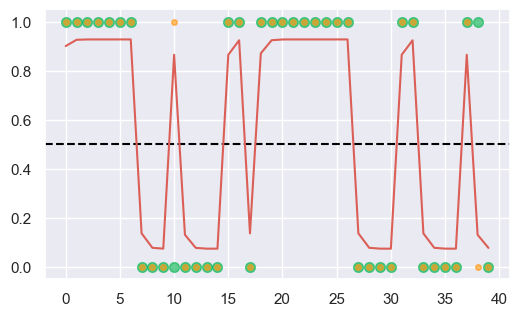

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.axhline(0.5, color='k', linestyle='--')
# Calcalte the probability of beign in state 1 from the forward tracker
p1_fwd = [p[1] for p in est.forward_tracker]
ax.plot(p1_fwd[:40])
ax.plot(state_ts[:40], 'o', color=sns.xkcd_rgb["shamrock"], markersize=7, alpha=0.6)
ax.plot(obs_ts[:40], 'o',color=sns.xkcd_rgb["tangerine"], markersize=4, alpha=0.6)

ax.set_ylim([-0.05,1.05])


In [6]:
# Now we can calculate the likelihood of this parameter

calc_likelihood(B, est.prediction_tracker, obs_ts)

669.7782209009188

In [7]:
# Now, we can write a function that loops over a bunch of values of the
# transition probability, and plots the likelihood function in terms of this
# parameter

def generate_likelihood_curve(B, obs_ts):
    # Initialize an estimation object
    est = infer.MarkovInfer(2, 2)
    # Set the candidate a values
    a_vals = np.linspace(0, 1, 100)
    # Initialize an empty list to build the likelihood function
    likelihood = []

    for a in a_vals:
        A_sample = np.array([[1 - a, a], [a, 1 - a]])
        est.forward_algo(obs_ts, A_sample, B)
        l = calc_likelihood(B, est.prediction_tracker, obs_ts)
        likelihood.append(l)

    return likelihood, a_vals

In [8]:
likelihood, a_vals = generate_likelihood_curve(B, obs_ts)
a_max_likely = a_vals[np.argmin(likelihood)]
a_max_likely, min(likelihood)

(0.30303030303030304, 662.2834242719365)

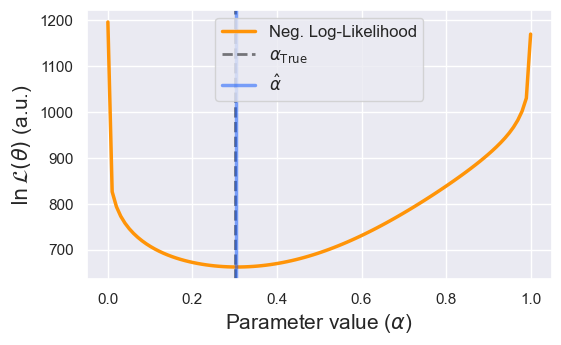

In [9]:
# This is the 'True' parameter value
a_true = 1 - A[0,0]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(a_vals, likelihood, linewidth=2.5, color=sns.xkcd_rgb["tangerine"], label="Neg. Log-Likelihood")
ax.axvline(a_true, color='k', linestyle='--', alpha=0.5, linewidth=2.0, label=r"$\alpha_{\rm True}$")
ax.axvline(a_max_likely, color=sns.xkcd_rgb["electric blue"], alpha=0.5, linewidth=2.5, label=r"$\hat{\alpha}$")
ax.set_xlabel(r"Parameter value ($\alpha$)", fontsize=15)
ax.set_ylabel(r"$\ln \mathcal{L}(\theta)$ (a.u.)", fontsize=15)
ax.legend(fontsize=12, frameon=True)
plt.show()

So, from this we are able to produce a reasonable estiamte of the transition matrix parameters. Now, lets go one step further, and assume that we also want to determine the parameters in the emission matrix ($B$), while still assuming that both $A$ and $B$ are symmetric, and that the hidden state trajectory is known. 

Specifically, the $\boldsymbol{A}$ and $\boldsymbol{B}$ matrices have the following form:

$$ \boldsymbol{A} = \left[ \begin{matrix} 1 - \alpha & \alpha \\ \alpha & 1 - \alpha \end{matrix} \right] \qquad \boldsymbol{B} = \left[ \begin{matrix} 1 - \beta & \beta \\ \beta & 1 - \beta \end{matrix} \right]$$

And so the likelihood function is 2-dimensional (it depends on $\alpha$ and $\beta$)

In [10]:
# First, we need to re-write our function to generate the likelihood into a 2D
# routine, this is relatively messy... but does the trick
def generate_likelihood_surface(
    obs_ts: Iterable[int], sample_dim: Optional[int] = 10
):
    est = infer.MarkovInfer(2, 2)

    a_vals = np.linspace(0.01, 0.99, sample_dim)
    b_vals = np.linspace(0.01, 0.99, sample_dim)

    # Initialize the likeihood grid
    likelihood = np.zeros((sample_dim, sample_dim))

    # Loop over all 'a' values
    for i, a in enumerate(a_vals):
        # Set the A matrix for this specific 'a'
        A_sample = np.array([[1 - a, a], [a, 1 - a]])
        # Loop over all 'b' values
        for j, b in enumerate(b_vals):
            # Set the B matrix for this specific 'b'
            B_sample = np.array([[1 - b, b], [b, 1 - b]])

            # Run the forward algorithm to get the bayesian filtered probabilities
            est.forward_algo(obs_ts, A_sample, B_sample)
            # This error handling handles exceptions that can occur near the
            # domain boundaries (a,b = 0 or 1)
            try:
                l = calc_likelihood(B_sample, est.prediction_tracker, obs_ts)
            except RuntimeWarning:
                l = None
            # Put the entry into the likelihood matrix
            likelihood[i, j] = l

    return likelihood, a_vals, b_vals

In [11]:
# We can test this for a small sample dimension (so that it runs fast-ish)
likelihood_coarse, aVals_coarse, bVals_coarse = generate_likelihood_surface(obs_ts, sample_dim=25)

In [12]:
b_est_idx, a_est_idx = likelihood_coarse.argmin() % 25, likelihood_coarse.argmin() // 25

In [13]:

# Based on symmetry, we also have this value (which will be clear from the heatmap)
b_est_idx_alt = 24 - 21
a_est_idx, b_est_idx

(5, 4)

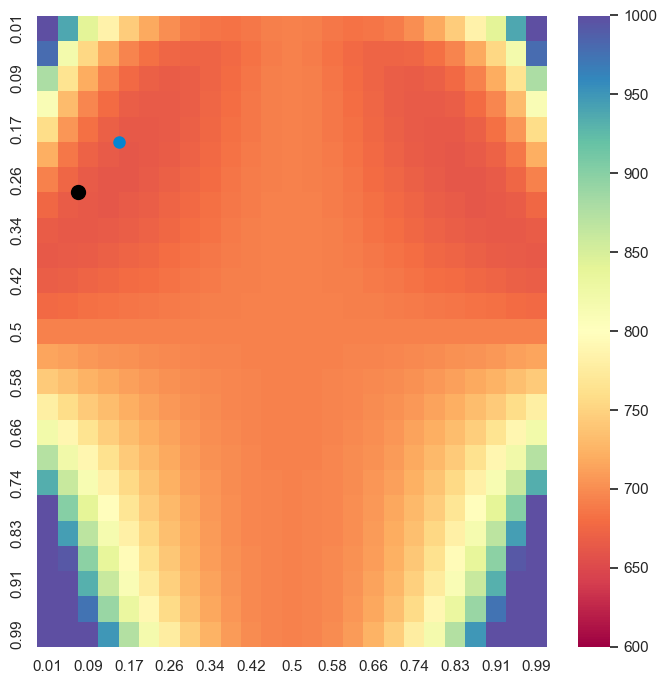

In [14]:
# And then we can plot it as a heatmap to make sure things look generally
# correct
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.heatmap(likelihood_coarse, cmap="Spectral", vmax=1000, vmin=600, ax=ax)

# Now plot the optimal and estimated parameter values
# recall these are the 'true' model parameters
a_true = 0.3
b_true = 0.1

ax.plot(
    [np.argmin(np.abs(b_true - bVals_coarse))],
    [np.argmin(np.abs(a_true - aVals_coarse))],
    'o', markersize=10, color=sns.xkcd_rgb["black"]
)
ax.plot([b_est_idx], [a_est_idx], 'o', markersize='8', color=sns.xkcd_rgb["cerulean"])
# ax.plot([b_est_idx_alt], [a_est_idx], 'o', markersize='8', color=sns.xkcd_rgb["cerulean"])

ax.set_xticks(ax.get_xticks()[::2])
ax.set_xticklabels([round(a, 2) for a in aVals_coarse[::2]])

ax.set_yticks(ax.get_yticks()[::2])
ax.set_yticklabels([round(b, 2) for b in bVals_coarse[::2]])
plt.tight_layout()

In [15]:
# from this, it looks like things are looking like the work reasonably well
# Aside from the issue with a local likelihood optima (two blue dots)
# So, we can keeep this in mind going forward.  However, for the time being,
# we can generate a higher resolution plot, and get a better handle on the 
# specific geometry of the likelihood surface here

In [16]:
# NOTE This cell takes a long time ~ 2.5 mins to run
likelihood, aVals, bVals = generate_likelihood_surface(obs_ts, sample_dim=100)

In [17]:
# And we can find the optimal parameter combination
flat_idx = likelihood.argmin()
b_idx = flat_idx % 100
a_idx = flat_idx // 100
a_idx, b_idx

(24, 15)

In [18]:
likelihood[a_idx, b_idx]

661.8190546426242

In [19]:
np.min(likelihood)

661.8190546426242

In [20]:
# Now that means the optimal parameters are:
a_opt = aVals[a_idx]
b_opt = bVals[b_idx]
a_opt, b_opt

(0.24757575757575756, 0.15848484848484848)

In [21]:
a_idx_true, b_idx_true = np.argmin(np.abs(aVals - 0.3)), np.argmin(np.abs(bVals - 0.1))

In [23]:
from pathlib import Path
proj_dir = Path().resolve().parents[1]
data_dir = proj_dir / "reports" / "figures"

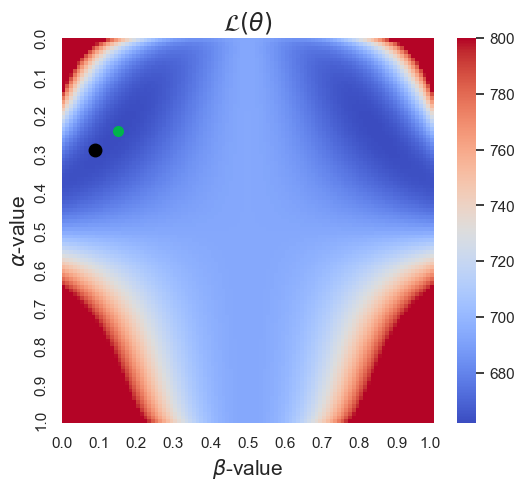

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(likelihood, cmap="coolwarm", ax=ax, vmax = 800)
ax.plot([b_idx_true], [a_idx_true], 'o', markersize=9, color='k')
ax.plot([b_idx], [a_idx], 'o', markersize=7, color=sns.xkcd_rgb["shamrock"])

idx_arr = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

ax.set_xticks(idx_arr)
ax.set_yticks(idx_arr)

ax.set_xticklabels(np.round(aVals[idx_arr], 1))
ax.set_yticklabels(np.round(aVals[idx_arr], 1))

ax.set_xlabel(r"$\beta$-value", fontsize=15)
ax.set_ylabel(r"$\alpha$-value", fontsize=15)
ax.set_title(r"$\mathcal{L}(\theta)$", fontsize=17)
plt.savefig(data_dir / "likelihood_surface.pdf")
plt.show()


So, this procedure (although it takes awhile for the resolution in the plot above) does appear to generally work. However, we assumed that our system was symmetric so that we only had two parameters in the likelihood function (and were optimizing a sort-of *partial likelihood* as opposed to the *complete-data likelihood function* that we will discuss in a near-future notebook). In scaling this to more complex systems that (for instance) have a higher number of dimensions, or do not impose symmetry, this time will take a long time to run. However, we could speed things up by, instead of sampling the entire function, performing a local optimization on the likelihood surface (such as, for instance, gradient descent). Given that we start in the correct basin, this will lead to convergence towards the local minimum.

Additionally, rather than our previous *brute force* approach to finding the optimal solution, we can make use of seomt of `python`'s supported optimizers, which include a global optimizer, that is much more sophistocated (and fast) thatn the one we have implemented.

Because we will find much more efficient and robust ways of calcualting local minima for this function, the routines created above are not supported in the package.